<div class="alert alert-info">
<h2> Оценка корректности проведения A/B-тестирования  <a class="tocSkip"></h2> 

<b>Цель:</b>  провести оценку полученных результатов A/B-теста.
    
<b>Задачи:</b>   
   1. Оценить корректность проведения теста:
    
        -пересечение тестовой аудитории с конкурирующим тестом
        
        -совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

   2. Проанализировать результаты теста.
 
<b>Содержание:</b>
   1. Предобработка данных;
   2. Оценка корректности проведения теста;
   3. Анализ данных;
   4. Оценка результатов теста;
   5. Общее заключение о корректности проведения теста.</div>

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import plotly.io as pio
from plotly import graph_objects as go
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
from scipy import stats as st
import math as mth

In [2]:
#датасет
events = pd.read_csv('/datasets/final_ab_events.csv')
market_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
participants = pd.read_csv('/datasets/final_ab_participants.csv')

### Предобработка таблицы market_events 
Календарь маркетинговых событий на 2020 год:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [3]:
market_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
#проверка типов данных
market_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [5]:
#изменение типа в start_dt и finish_dt
market_events['start_dt'] = pd.to_datetime(market_events['start_dt'])
market_events['finish_dt'] = pd.to_datetime(market_events['finish_dt'])
market_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [6]:
# проверка пропусков
market_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [7]:
# проверка явных дубликатов
market_events.duplicated().sum()

0

In [8]:
#проверка дубликатов с комбинацией название событий и региона
market_events['location'] = market_events['name'] + market_events['regions']
market_events['location'].duplicated().sum()

0

In [9]:
#проверка регионов на повторы
market_events['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [10]:
#проверка событий на повторы
market_events['name'].unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

In [11]:
print('Дата начала события:', market_events['start_dt'].min())
print('Дата окончания события:', market_events['finish_dt'].max())

Дата начала события: 2020-01-25 00:00:00
Дата окончания события: 2021-01-07 00:00:00


**Вывод по таблице market_events:** 
- В столбцах start_dt и finish_dt были изменен тип данных;
- Пропусков не обнаружено;
- Дубликатов не обнаружено;
- Единственное, календарь маркетинговых событий заявлен только на 2020 год, но при проверке в данных есть события которые заканчиваются 2021 году.

### Предобработка таблицы new_users 
пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.:
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [12]:
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [13]:
#проверка типов данных
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [14]:
#изменение типа в first_date
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [15]:
# проверка пропусков
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [16]:
# проверка явных дубликатов
new_users.duplicated().sum()

0

In [17]:
#проверка регионов на повторы
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [18]:
#проверка устройств на повторы
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [19]:
print('Дата начала регистрации:', new_users['first_date'].min())
print('Дата окончания регистрации:', new_users['first_date'].max())

Дата начала регистрации: 2020-12-07 00:00:00
Дата окончания регистрации: 2020-12-23 00:00:00


In [20]:
new_users[new_users['first_date'] > '2020-12-21 00:00:00']

,user_id,first_date,region,device
23821,5815F7ECE74D949F,2020-12-22,CIS,PC
23822,32EAEA5E903E3BC1,2020-12-22,N.America,Android
23823,9DF7A3C46487EF0B,2020-12-22,EU,Android
23824,ADE98C6440423287,2020-12-22,EU,iPhone
23825,5A5833D3AEA75255,2020-12-22,N.America,PC
...,...,...,...,...
33290,165AFCBF42C043F8,2020-12-23,EU,PC
33291,54E7F36C0E976E24,2020-12-23,EU,Android
33292,7E43EB2E03A33E78,2020-12-23,EU,PC
33293,B8B679DEE9F2CA06,2020-12-23,EU,PC


**Вывод по таблице new_users:** 
- В столбце first_date был изменен тип данных;
- Пропусков не обнаружено;
- Дубликатов не обнаружено;
- Было заявлено, что были взяты пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года. При проверке в данных есть 5263 пользователя, зарегистрировавшиеся после 21 декабря 2020 года.

### Предобработка таблицы events 
Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [21]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [22]:
#проверка типов данных таблицы
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [23]:
#изменение типа в event_dt
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [24]:
# проверка пропусков
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [25]:
# проверка пропусков в details
events[events['details'].isna()].sort_values(by='user_id', ascending=False)

,user_id,event_dt,event_name,details
110810,FFFFE36C0F6E92DF,2020-12-23 05:09:15,product_cart,NaN
214566,FFFFE36C0F6E92DF,2020-12-22 11:38:57,product_page,NaN
421990,FFFFE36C0F6E92DF,2020-12-26 09:25:03,login,NaN
107091,FFFFE36C0F6E92DF,2020-12-22 11:38:57,product_cart,NaN
396849,FFFFE36C0F6E92DF,2020-12-23 05:09:13,login,NaN
...,...,...,...,...
162871,0001710F4DDB1D1B,2020-12-15 17:34:23,product_page,NaN
78020,0001710F4DDB1D1B,2020-12-14 20:20:42,product_cart,NaN
81415,0001710F4DDB1D1B,2020-12-15 17:34:25,product_cart,NaN
307611,0001710F4DDB1D1B,2020-12-15 17:34:22,login,NaN


In [26]:
# подсчет явных дубликатов
events.duplicated().sum()

0

In [27]:
print('Начальная дата и время события:', events['event_dt'].min())
print('Последняя дата и время события:', events['event_dt'].max())

Начальная дата и время события: 2020-12-07 00:00:33
Последняя дата и время события: 2020-12-30 23:36:33


**Вывод по таблице events:** 
- В столбце first_date был изменен тип данных;
- Пропуски были обнаружены в столбце details - 377577. Поскольку количество пропусков большое, изменив их есть значительный риск влияния на результаты, поэтому я решила их оставить пока без изменений;
- Дубликатов не обнаружено;
- Было заявлено, что были взяты действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года. При проверке в данных не обнаружено пользователей за пять дней. Последняя дата действий была 30 декабря 2020 года.

### Предобработка таблицы participants 
таблица участников тестов:
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [28]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


In [29]:
#проверка типов данных таблицы
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [30]:
# проверка пропусков
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [31]:
# подсчет явных дубликатов
participants.duplicated().sum()

0

**Вывод по таблице participants:** 
- Необходимости в изменении типа данных не было;
- Пропусков не обнаружено;
- Дубликатов не обнаружено.

## Оценка корректности проведения теста

Техническое задание
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

In [32]:
#соединила две таблицы по user_id: new_users и participants 
merge_data = new_users.merge(participants, on='user_id', how='left')
merge_data

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,NaN,NaN
...,...,...,...,...,...,...
63330,1DB53B933257165D,2020-12-20,EU,Android,NaN,NaN
63331,538643EB4527ED03,2020-12-20,EU,Mac,NaN,NaN
63332,7ADEE837D5D8CBBD,2020-12-20,EU,PC,NaN,NaN
63333,1C7D23927835213F,2020-12-20,EU,iPhone,B,interface_eu_test


In [33]:
#добавила в новую таблицу - таблицу events
merge_data = merge_data.merge(events, on='user_id', how='left')
merge_data

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN
2,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN,2020-12-07 16:38:09,product_page,NaN
3,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN,2020-12-08 02:02:34,product_page,NaN
4,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN,2020-12-23 14:35:41,product_page,NaN
...,...,...,...,...,...,...,...,...,...
449951,1C7D23927835213F,2020-12-20,EU,iPhone,B,interface_eu_test,2020-12-23 15:47:23,login,NaN
449952,1C7D23927835213F,2020-12-20,EU,iPhone,B,interface_eu_test,2020-12-25 12:31:04,login,NaN
449953,1C7D23927835213F,2020-12-20,EU,iPhone,B,interface_eu_test,2020-12-27 03:51:35,login,NaN
449954,8F04273BB2860229,2020-12-20,EU,Android,NaN,NaN,2020-12-20 03:17:17,product_cart,NaN


In [34]:
#подсчет количества уникальных пользователей
merge_data_id = merge_data['user_id'].nunique()
print('Количество пользователей:', merge_data_id)

Количество пользователей: 61733


In [35]:
#подсчет количества уникальных пользователей в тестах
merge_data_test = merge_data.groupby(['ab_test']).agg({'user_id': 'nunique'}).reset_index()
merge_data_test['percent'] = round((merge_data_test['user_id']/merge_data_test['user_id'].sum()),3)*100
merge_data_test

,ab_test,user_id,percent
0,interface_eu_test,11567,63.3
1,recommender_system_test,6701,36.7


In [36]:
#подсчет количества пользователей и их процент в тесте inter_test_participants по группам
inter_test_participants = merge_data[merge_data['ab_test'] == 'interface_eu_test'].groupby('group')['user_id'].nunique().reset_index()
inter_test_participants['percent'] = round((inter_test_participants['user_id']/inter_test_participants['user_id'].sum()),3)*100
inter_test_participants

,group,user_id,percent
0,A,5831,50.4
1,B,5736,49.6


In [37]:
#подсчет количества пользователей и их процент в тесте recommender_system_test по группам
rec_test_participants = merge_data[merge_data['ab_test'] == 'recommender_system_test'].groupby('group')['user_id'].nunique().reset_index()
rec_test_participants['percent'] = round((rec_test_participants['user_id']/rec_test_participants['user_id'].sum()),3)*100
rec_test_participants

,group,user_id,percent
0,A,3824,57.1
1,B,2877,42.9


**Проверка:** Соединила три таблицы. Количество уникальных пользователей 61733. Из них в теста участвуют 18268 пользователей. 
В отобранном в задании тестем (recommender_system_test) участвуют 6701 пользователей, что чуть выше ожидаемого (6000).
Распределение количества пользователей в каждой группе теста относительно равномерное.

In [38]:
# просмотрела кто входит в какие группы тестов
both_tests = merge_data[(merge_data['ab_test'] == 'recommender_system_test')|(merge_data['ab_test'] == 'interface_eu_test')]
test_group_count = both_tests.groupby('user_id').agg({'ab_test': 'unique', 'group': 'unique'}).reset_index()
test_group_count

,user_id,ab_test,group
0,0002CE61FF2C4011,[interface_eu_test],[A]
1,000ABE35EE11412F,[recommender_system_test],[A]
2,001064FEAAB631A1,"[recommender_system_test, interface_eu_test]",[B]
3,0010A1C096941592,[recommender_system_test],[A]
4,001C05E87D336C59,[recommender_system_test],[A]
...,...,...,...
16661,FFE858A7845F005E,[recommender_system_test],[A]
16662,FFED90241D04503F,"[recommender_system_test, interface_eu_test]",[B]
16663,FFEFC0E55C1CCD4F,[interface_eu_test],[B]
16664,FFF28D02B1EACBE1,"[recommender_system_test, interface_eu_test]","[B, A]"


In [39]:
# подсчёт пользователей, которые входят в две группы
two_test_group = (
merge_data
    .groupby('user_id')
    .agg({'ab_test': 'unique','group' : 'nunique'})
    .query('group>1')
)
two_test_group.reset_index()


,user_id,ab_test,group
0,0082295A41A867B5,"[recommender_system_test, interface_eu_test]",2
1,00E68F103C66C1F7,"[recommender_system_test, interface_eu_test]",2
2,02313B9E82255F47,"[recommender_system_test, interface_eu_test]",2
3,023D4A062F40F10B,"[recommender_system_test, interface_eu_test]",2
4,040F6DD6E792D0AB,"[recommender_system_test, interface_eu_test]",2
...,...,...,...
771,FEA0C585A53E7027,"[recommender_system_test, interface_eu_test]",2
772,FEC0BCA6C323872F,"[recommender_system_test, interface_eu_test]",2
773,FEE7040D7D2F2968,"[recommender_system_test, interface_eu_test]",2
774,FFC53FD45DDA5EE8,"[recommender_system_test, interface_eu_test]",2


In [40]:
#есть ли значения, которые встречаются в обеих тестовых группах в тесте recommender_system_test
len(np.intersect1d(merge_data[merge_data['ab_test'] == 'recommender_system_test'].query('group == "A"')['user_id'].unique(), merge_data[merge_data['ab_test'] == 'recommender_system_test'].query('group == "B"')['user_id'].unique()))


0

In [41]:
#есть ли значения, которые встречаются в обеих тестовых группах в тесте interface_eu_test
len(np.intersect1d(merge_data[merge_data['ab_test'] == 'interface_eu_test'].query('group == "A"')['user_id'].unique(), merge_data[merge_data['ab_test'] == 'interface_eu_test'].query('group == "B"')['user_id'].unique()))


0

**Проверка:** Всего 16666 пользователей, принимающие участие в тестах, входят в одну или две группы. Из них в две группы входят 776 пользователей. При проверке значений в каждом тесте, не было найдено тех, которые встречаются и в А и в В тестовых группах. Все пользователи уникальны в каждой группе двух тестов.

In [42]:
#посчитала количество пользователей и их процент по регионам
merge_data_region = merge_data.pivot_table(index='region', values='user_id', aggfunc='nunique').reset_index()
merge_data_region['percent'] = round((merge_data_region['user_id']/merge_data_region['user_id'].sum()),3)*100
merge_data_region

,region,user_id,percent
0,APAC,3153,5.1
1,CIS,3155,5.1
2,EU,46270,75.0
3,N.America,9155,14.8


In [43]:
#отфильтровала из обшего количества пользователей, пользователей с EU
users_eu = merge_data[merge_data['region'] == 'EU']
users_eu_count =users_eu['user_id'].nunique()
print('Количество пользователей с EU от общего числа пользователей:', users_eu_count)

Количество пользователей с EU от общего числа пользователей: 46270


**Проверка:** При проверки аудитории, вместо заявленных 15% новых пользователей из региона EU, были выявлены 75%. Более того, помимо завляенного региона EU были трех других регионов, которые составили 25%.

In [44]:
#подсчет количества новых пользователей только с EU
new_users_reg = new_users[(new_users['first_date'] > '2020-12-07 00:00:00')&(new_users['first_date'] < '2020-12-21 00:00:00')] 
new_users_eu = new_users_reg[new_users_reg['region'] == 'EU']
new_users_eu

,user_id,first_date,region,device
5596,F0D1A8FA8FE991C0,2020-12-14,EU,Android
5597,110698ABD2231897,2020-12-14,EU,Android
5598,E8C28FE61CA9EE81,2020-12-14,EU,Android
5599,2DEF2EDF78F1EF61,2020-12-14,EU,iPhone
5600,2C65B1FF2DD263D9,2020-12-14,EU,Android
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [45]:
#для проверки выделила есть ли значения по EU новых пользователей, которые встречаются в основной таблице и их процент
merge_data_eu_count = len(np.intersect1d(merge_data[merge_data['region'] == 'EU']['user_id'].unique(), new_users_eu[new_users_eu['region'] == 'EU']['user_id'].unique()))
print('Количество новых пользователей с EU:', merge_data_eu_count)
print('Процент новых пользователей с EU:', round((merge_data_eu_count/merge_data_id),3)*100)


Количество новых пользователей с EU: 33485
Процент новых пользователей с EU: 54.2


In [46]:
#создала новую таблицу с теста recommender_system и посчитала количество пользователей
data_test = merge_data.query("ab_test == 'recommender_system_test'")
data_test_count = data_test['user_id'].nunique()
print('Количество пользователей теста recommender_system от общего числа пользователей:', data_test_count)

#отфильтровала только новых пользователей и посчитала их
new_users_test = data_test[(data_test['first_date'] > '2020-12-07 00:00:00')&(data_test['first_date'] < '2020-12-21 00:00:00')] 
new_users_test_count= new_users_test['user_id'].nunique()
print('Количество новых пользователей теста recommender_system от общего числа пользователей:', new_users_test_count)

#отфильтровала только новых пользователей с EU
new_users_test_eu = new_users_test[new_users_test['region'] == 'EU']
new_users_test_eu_count = new_users_test_eu['user_id'].nunique()
print('Количество новых пользователей теста recommender_system от числа пользователей с EU:', new_users_test_eu_count)

#посчитала долю новых пользователей с EU в тесте от всего количества пользователей с EU
users_eu_test_percent = new_users_test_eu_count/merge_data_eu_count*100
print('Количество новых пользователей теста recommender_system от числа пользователей с EU:', users_eu_test_percent)

Количество пользователей теста recommender_system от общего числа пользователей: 6701
Количество новых пользователей теста recommender_system от общего числа пользователей: 5333
Количество новых пользователей теста recommender_system от числа пользователей с EU: 5060
Количество новых пользователей теста recommender_system от числа пользователей с EU: 15.11124384052561


**Вывод:** Из общего количества пользователей с EU (46270) новых пользователей составило 33485. В тесте recommender_system участвуют 6701 пользователей, из них новых пользователей 5333 и с EU -5060. То есть доля новых пользователей с EU участвующих в тесте recommender_system составило 15.1%.  

In [47]:
#проверка дат событий
print('дата запуска:', events['event_dt'].min())
print('дата набора новых пользователей:', new_users['first_date'].max())
print('дата остановки:', events['event_dt'].max())

дата запуска: 2020-12-07 00:00:33
дата набора новых пользователей: 2020-12-23 00:00:00
дата остановки: 2020-12-30 23:36:33


In [48]:
#проверка совпадения с прохождением маркетинговой активности во время запуска
market_events.query('start_dt in ["2020-12-07","2020-12-30"]')

,name,regions,start_dt,finish_dt,location
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07,CIS New Year Gift LotteryCIS


In [49]:
#проверка совпадения с прохождением маркетинговой активности во время окончания
market_events.query('finish_dt in ["2020-12-07","2020-12-30"]')

,name,regions,start_dt,finish_dt,location


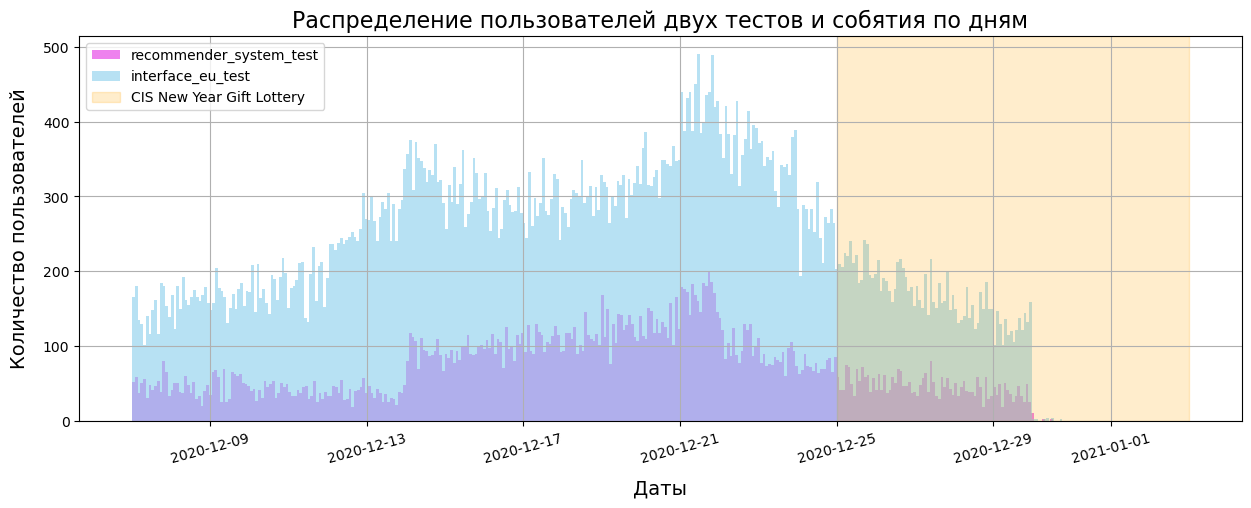

In [50]:
#график распределения пользователей двух тестов и собятия по дням"
merge_data[merge_data['ab_test'] == 'recommender_system_test']['event_dt'].hist(bins = 14*24,  figsize=(15, 5), color = 'violet', label = 'recommender_system_test', alpha=1)
merge_data[merge_data['ab_test'] == 'interface_eu_test']['event_dt'].hist(bins = 14*24,  figsize=(15, 5), color = 'skyblue', label = 'interface_eu_test', alpha=.6)
plt.axvspan('2020-12-25', '2021-01-03', color='orange', alpha=.2, label = 'CIS New Year Gift Lottery')
plt.title("Распределение пользователей двух тестов и собятия по дням", fontsize=16)
plt.xlabel("Даты", labelpad=10, weight='normal', size=14)
plt.ylabel("Количество пользователей", labelpad=10, weight='normal', size=14)
plt.xticks(rotation=15)
plt.legend()
plt.show()

**Проверка:** По техническому заданию дата остановки набора новых пользователей должна была быть 21 декабря 2020. Как было выявлено ранее, 5263 пользователей зарегистрировались после указанного времени. Также было выявлено, что дата остановки теста была 30 декабря 2020 года. Однако, заявленной датой остановки было 4 января 2021 года, то есть отсутствуют данные пользователей за пять дней.
Кроме этого, во время проведения теста было выявлено совпадение с прохождением маркетинговой активности, а точнее CIS New Year Gift Lottery.

## Исследовательский анализ данных

### Количество событий на пользователя одинаково распределены в выборках?

In [51]:
#в таблице с пользователями EU отфильтровала тех, которые участвовали в тесте recommender_system
data_filtered = users_eu.query("ab_test == 'recommender_system_test'")
#отфильтровала по дате начала и конца теста
data_filtered = data_filtered[(data_filtered['first_date'] < '2020-12-21 00:00:00')]
data_filtered = data_filtered[(data_filtered['event_dt'] < '2021-01-04 00:00:00')]
#отфильтровала за 14 дней с момента регистрации в системе
data_filtered = data_filtered[data_filtered['event_dt'] < data_filtered['first_date']+pd.DateOffset(14)]
merge_data = data_filtered
merge_data

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN
146,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN
147,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN
148,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
449812,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,product_page,NaN
449813,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:51,product_page,NaN
449814,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:25,login,NaN
449815,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,login,NaN


In [52]:
#подсчет количества событий
merge_data_event = merge_data['event_name'].count()
print('Количество событий:', merge_data_event)

#подсчет типов событий
merge_data_event_type = merge_data['event_name'].nunique()
print('Количество типов событий:', merge_data_event_type)

#подсчет количества пользователей в среденем
merge_data_event_mean = round(merge_data_event/merge_data_id, 1)
print('Количество событий на пользователя в среднем:', merge_data_event_mean)

Количество событий: 19601
Количество типов событий: 4
Количество событий на пользователя в среднем: 0.3


In [53]:
#подсчет количества каждого события
merge_data['event_name'].value_counts().sort_values(ascending=False)

login           8872
product_page    5454
purchase        2666
product_cart    2609
Name: event_name, dtype: int64

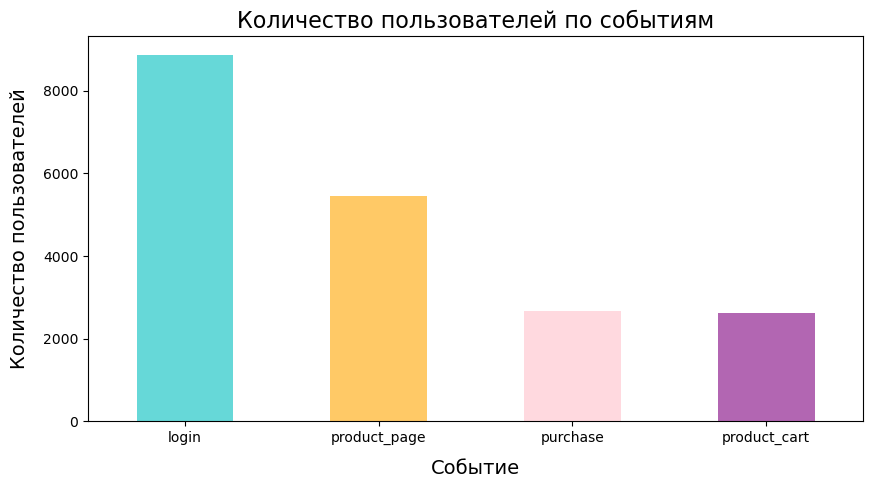

In [54]:
#график количество пользователей по событиям
(merge_data['event_name'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color = ['c', 'orange', 'pink', 'purple', 'lightsteelblue'], alpha =.6))
plt.title("Количество пользователей по событиям", fontsize=16)
plt.xlabel("Событие", labelpad=10, weight='normal', size=14)
plt.ylabel("Количество пользователей", labelpad=10, weight='normal', size=14)
plt.xticks(rotation = 360);

In [55]:
#проверка числа событий в выборках распределения по дням
event_count = merge_data.groupby('event_dt').agg({'event_name': 'unique', 'user_id': 'count'}).sort_values(by='user_id', ascending=False).reset_index()
event_count.head(10)

,event_dt,event_name,user_id
0,2020-12-09 19:01:05,"[purchase, product_cart, login, product_page]",6
1,2020-12-17 01:42:01,"[product_cart, product_page, purchase, login]",5
2,2020-12-17 20:13:22,"[login, purchase, product_cart, product_page]",5
3,2020-12-10 14:54:17,"[product_cart, product_page, login]",5
4,2020-12-20 09:51:02,"[purchase, product_page, login]",5
5,2020-12-18 18:44:29,"[product_page, login, product_cart]",5
6,2020-12-07 22:33:04,"[purchase, product_cart, product_page, login]",4
7,2020-12-16 14:04:35,"[purchase, product_cart, product_page, login]",4
8,2020-12-12 13:00:15,"[purchase, product_cart, product_page, login]",4
9,2020-12-21 09:33:49,"[product_page, purchase, login]",4


In [56]:
event_count['user_id'].unique()

array([6, 5, 4, 3, 2, 1], dtype=int64)

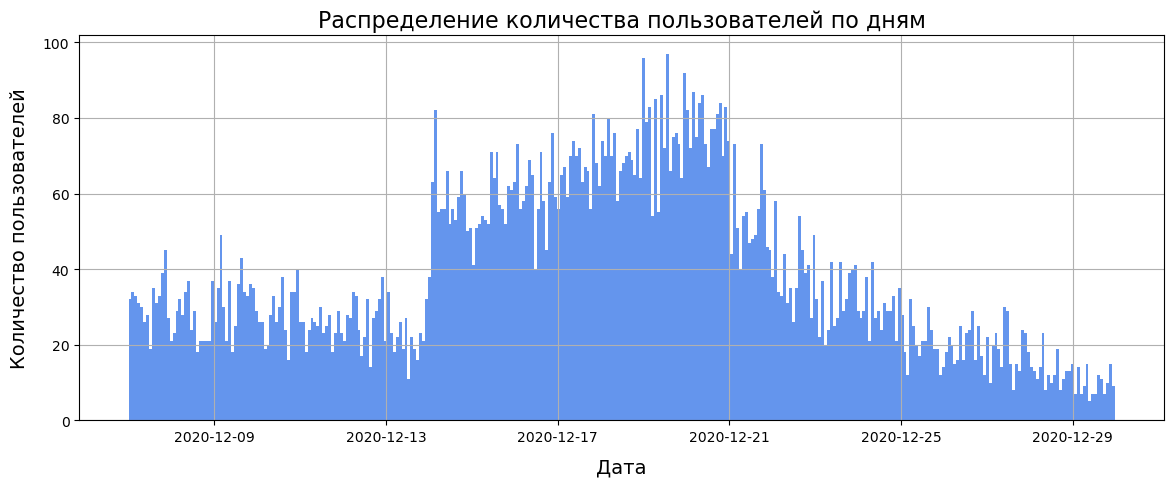

In [57]:
#гистограмма по дате на весь период
event_count['event_dt'].hist(bins=14*24, figsize=(14, 5), color='cornflowerblue').set_title('Распределение количества пользователей по дням', fontsize=16)
plt.xlabel("Дата", labelpad=10, weight='normal', size=14)
plt.ylabel("Количество пользователей", labelpad=10, weight='normal', size=14)
plt.show()

In [58]:
#отдельный подсчет распределения количества пользователей теста recommender_system по дням
rec_test_count_dt = merge_data[merge_data['ab_test'] == 'recommender_system_test'].groupby('event_dt').agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False).reset_index()
rec_test_count_dt

,event_dt,user_id
0,2020-12-09 19:01:05,6
1,2020-12-17 01:42:01,5
2,2020-12-17 20:13:22,5
3,2020-12-10 14:54:17,5
4,2020-12-20 09:51:02,5
...,...,...
13102,2020-12-16 22:51:41,1
13103,2020-12-16 22:55:39,1
13104,2020-12-16 22:57:02,1
13105,2020-12-16 22:57:04,1


In [59]:
rec_test_count_dt['user_id'].unique()

array([6, 5, 4, 3, 2, 1], dtype=int64)

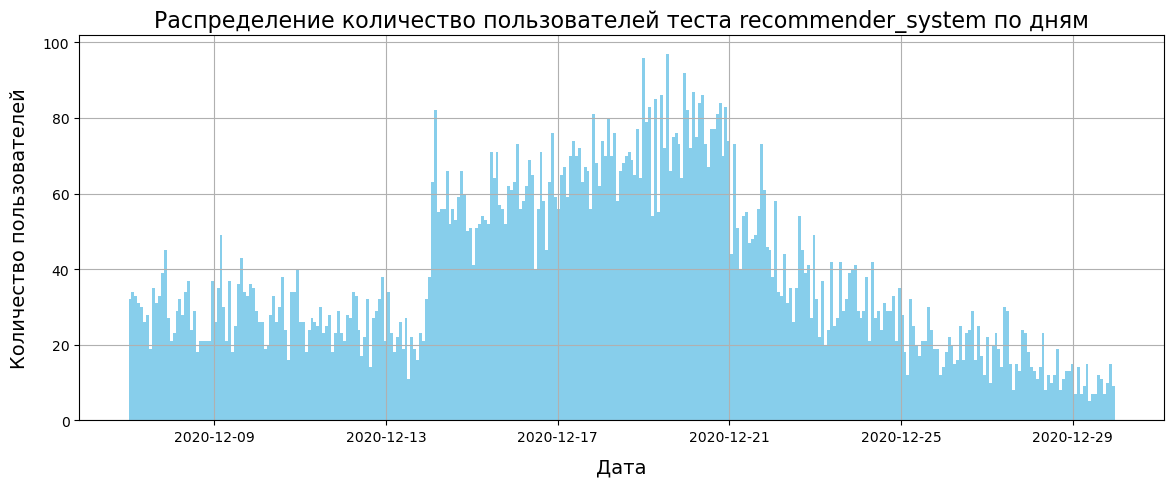

In [60]:
#график распределения количества пользователей теста recommender_system по дням
rec_test_count_dt['event_dt'].hist(bins=14*24, figsize=(14, 5), color='skyblue').set_title('Распределение количество пользователей теста recommender_system по дням', fontsize=16)
plt.xlabel("Дата", labelpad=10, weight='normal', size=14)
plt.ylabel("Количество пользователей", labelpad=10, weight='normal', size=14)
plt.show();

In [61]:
#подсчет количества каждого события с процентом
merge_event_count = merge_data.pivot_table(index='event_name', values='user_id', aggfunc='count').reset_index()
merge_event_count ['percent'] = round((merge_event_count['user_id']/merge_data_event),3)*100
#расположение событий в логическом порядке
merge_event_count['event_name'] = pd.Categorical(merge_event_count['event_name'], ['login', 'product_page', 'product_cart', 'purchase'])
merge_event_count = merge_event_count.sort_values('event_name').reset_index(drop= True)
merge_event_count

,event_name,user_id,percent
0,login,8872,45.3
1,product_page,5454,27.8
2,product_cart,2609,13.3
3,purchase,2666,13.6


При подсчете количества пользователей совершивших каждое из представленных событий, на первом месте выходит событие "login", то есть вход в свой аккаунт. За ним идет просмотр карточек товаров, далее по количеству следует покупка и за ним просмотр корзины.

In [62]:
#была подсчитана доля пользователей в отношении событий по последовательности
pd.options.mode.chained_assignment = None
merge_event_count['ratio_event'] = 0
for i in range(4):
    if i == 0:
        merge_event_count['ratio_event'].loc[i] = 100
    else:
        merge_event_count['ratio_event'].loc[i] = round((merge_event_count['user_id'].loc[i]/merge_event_count['user_id'].loc[i-1]),3)*100
merge_event_count    

,event_name,user_id,percent,ratio_event
0,login,8872,45.3,100.0
1,product_page,5454,27.8,61.5
2,product_cart,2609,13.3,47.8
3,purchase,2666,13.6,102.2


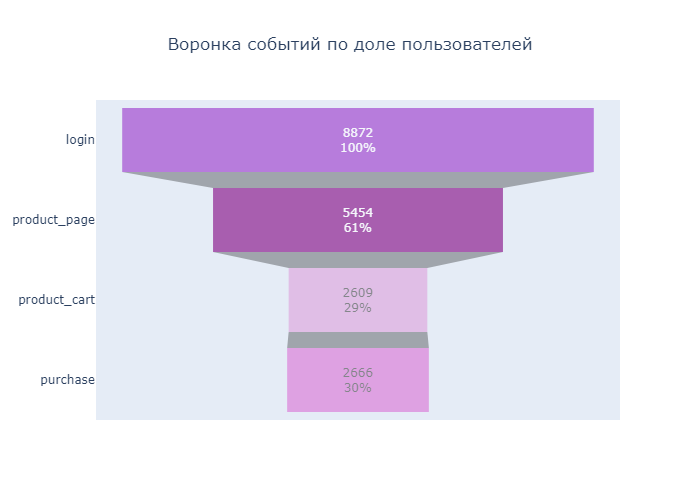

In [63]:
#была построена воронка событий
fig = go.Figure(go.Funnel(y=merge_event_count['event_name'], x=merge_event_count['user_id'], textposition = "inside", 
    textinfo = "value+percent initial", opacity = 0.6,marker = {"color": ["darkorchid", "purple", "plum", "orchid"]}))
fig.update_layout(title='Воронка событий по доле пользователей', title_x = 0.5 )
fig.show('png')

- было посчитано отношение числа пользователей между событиями:
  - событие "product_page" (В) к количеству пользователей с событием "login" (А) показало 66,2%
  - отношение числа пользователей с событием "purchase" (С) к количеству пользователей с событием "product_page" (В) - 50%
  - отношение числа пользователей с событием "product_cart" (D) к количеству пользователей с событием "purchase" (С) - 99,4%
- была построена диграмма воронки событий, в котором можно видеть изменение доли пользователей на каждом событии. Только 33% пользователей кладут выбранные продукты в корзину  и покупают их.

В техническом задании был выделен пункт об ожидаемом эффекте, которые звучал следующим образом:
за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase

Поэтому далее были проверены пользователи за 1 день и 14 дней регистрации.

In [64]:
#выделила отдельно пользователей теста recommender_system за 1 день регистрации
rec_test = merge_data[merge_data['ab_test'] == 'recommender_system_test']
rec_test_day_one = rec_test[rec_test['event_dt'] < rec_test['first_date']+pd.DateOffset(1)]
rec_test_day_one

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN
146,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN
152,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:53,login,NaN
186,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test,2020-12-07 06:50:29,purchase,4.99
...,...,...,...,...,...,...,...,...,...
449804,574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test,2020-12-20 04:15:43,product_page,NaN
449806,574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test,2020-12-20 04:15:43,login,NaN
449808,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:25,purchase,4.99
449811,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:26,product_page,NaN


In [65]:
#посчитала количество каждого события за 1 день регистрации пользователей теста recommender_system с процентом
rec_one_funnel = rec_test_day_one.pivot_table(index='event_name', values='user_id', aggfunc='count').reset_index()
rec_one_funnel['event_name'] = pd.Categorical(rec_one_funnel['event_name'], ['login', 'product_page', 'product_cart', 'purchase'])
rec_one_funnel = rec_one_funnel.sort_values('event_name').reset_index(drop= True)
rec_one_funnel['percent'] = round((rec_one_funnel['user_id']/rec_one_funnel['user_id'].sum()),3)*100
rec_one_funnel

,event_name,user_id,percent
0,login,2978,44.9
1,product_page,1854,27.9
2,product_cart,889,13.4
3,purchase,918,13.8


In [66]:
#была подсчитана доля пользователей за 1 день регистрации на тест recommender_system в отношении событий по последовательности
pd.options.mode.chained_assignment = None
rec_one_funnel['ratio_event'] = 0
for i in range(4):
    if i == 0:
        rec_one_funnel['ratio_event'].loc[i] = 100
    else:
        rec_one_funnel['ratio_event'].loc[i] = round((rec_one_funnel['user_id'].loc[i]/rec_one_funnel['user_id'].loc[i-1]),3)*100

rec_one_funnel

,event_name,user_id,percent,ratio_event
0,login,2978,44.9,100.0
1,product_page,1854,27.9,62.3
2,product_cart,889,13.4,48.0
3,purchase,918,13.8,103.3


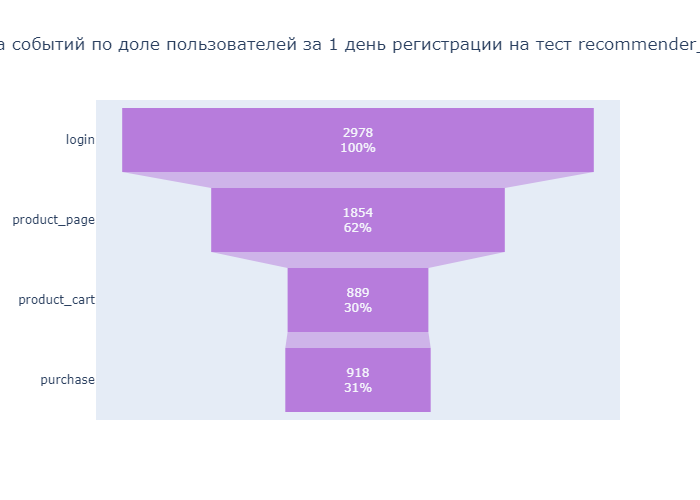

In [67]:
#была построена воронка событий за 1 день регистрации пользователей теста recommender_system
fig = go.Figure(go.Funnel(y=rec_one_funnel['event_name'], x=rec_one_funnel['user_id'], textposition = "inside", 
    textinfo = "value+percent initial", opacity = 0.6, marker = {"color": "darkorchid"}))
fig.update_layout(title='Воронка событий по доле пользователей за 1 день регистрации на тест recommender_system', title_x = 0.5 )
fig.show('png')

**Выводы:**
При исправлении данных и перестановке событий по логическому порядку отношение числа пользователей между событиями за 1 день регистрации на тест recommender_system показали следующее:
  - событие "product_page" (В) к количеству пользователей с событием "login" (А) показало 62,3%
  - отношение числа пользователей с событием "product_cart" (С) к количеству пользователей с событием "product_page" (В) - 48%
  - отношение числа пользователей с событием "purchase" (D) к количеству пользователей с событием "product_cart" (С) - 103,3%
  - отношение числа пользователей с событием "purchase" (D) с событием "login" (А) показало 30,8%

In [68]:
#выделила отдельно пользователей теста recommender_system за 14 дней с момента регистрации
# rec_test_day_14 = rec_test[(rec_test['event_dt'] > rec_test['first_date']+pd.DateOffset(13)) & (rec_test['event_dt'] < rec_test['first_date']+pd.DateOffset(14))]
rec_test_day_14 = rec_test[rec_test['event_dt'] < rec_test['first_date']+pd.DateOffset(14)]
rec_test_day_14


,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN
146,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN
147,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN
148,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
449812,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,product_page,NaN
449813,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:51,product_page,NaN
449814,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:25,login,NaN
449815,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,login,NaN


In [69]:
#посчитала количество каждого события за 14 день с момента регистрации пользователей теста recommender_system с процентом
rec_ft_funnel = rec_test_day_14.pivot_table(index='event_name', values='user_id', aggfunc='count').reset_index()
rec_ft_funnel['event_name'] = pd.Categorical(rec_ft_funnel['event_name'], ['login', 'product_page', 'product_cart', 'purchase'])
rec_ft_funnel = rec_ft_funnel.sort_values('event_name').reset_index(drop= True)
rec_ft_funnel['percent'] = round((rec_ft_funnel['user_id']/rec_ft_funnel['user_id'].sum()),3)*100
rec_ft_funnel

,event_name,user_id,percent
0,login,8872,45.3
1,product_page,5454,27.8
2,product_cart,2609,13.3
3,purchase,2666,13.6


In [70]:
#была подсчитана доля пользователей за 14 день с момента регистрации на тест recommender_system в отношении событий по последовательности
pd.options.mode.chained_assignment = None
rec_ft_funnel['ratio_event'] = 0
for i in range(4):
    if i == 0:
        rec_ft_funnel['ratio_event'].loc[i] = 100
    else:
        rec_ft_funnel['ratio_event'].loc[i] = round((rec_ft_funnel['user_id'].loc[i]/rec_ft_funnel['user_id'].loc[i-1]),3)*100

rec_ft_funnel

,event_name,user_id,percent,ratio_event
0,login,8872,45.3,100.0
1,product_page,5454,27.8,61.5
2,product_cart,2609,13.3,47.8
3,purchase,2666,13.6,102.2


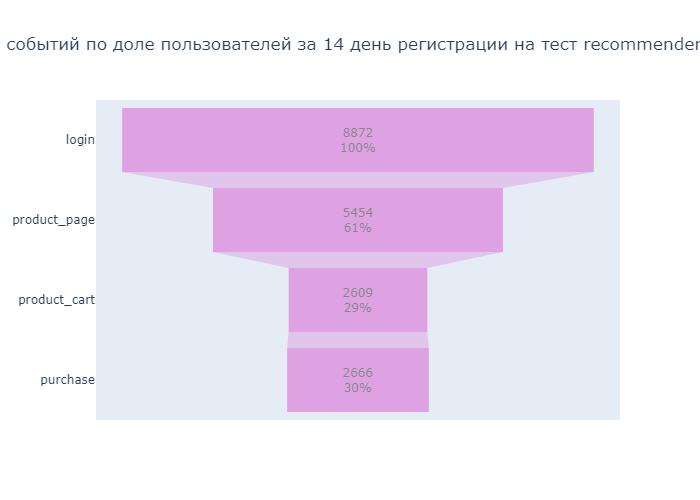

In [71]:
#была построена воронка событий зза 14 день с момента регистрации пользователей теста recommender_system
fig = go.Figure(go.Funnel(y=rec_ft_funnel['event_name'], x=rec_ft_funnel['user_id'], textposition = "inside", 
    textinfo = "value+percent initial", opacity = 0.6, marker = {"color": "orchid"}))
fig.update_layout(title='Воронка событий по доле пользователей за 14 день регистрации на тест recommender_system', title_x = 0.5 )
fig.show('png')

**Выводы:**
При исправлении данных и перестановке событий по логическому порядку отношение числа пользователей между событиями за 14 день регистрации на тест recommender_system показали следующее:
  - событие "product_page" (В) к количеству пользователей с событием "login" (А) показало 61,5%
  - отношение числа пользователей с событием "product_cart" (С) к количеству пользователей с событием "product_page" (В) - 47,8%
  - отношение числа пользователей с событием "purchase" (D) к количеству пользователей с событием "product_cart" (С) - 102,2%
  - отношение числа пользователей с событием "purchase" (D) с событием "login" (А) показало 30%

**Выводы по ожидаемому эффекту:**за 14 дней с момента регистрации в системе пользователи не показали значительного улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров(product_page) уменьшились на 1%
- просмотры корзины (product_cart) уменьшились на 1%
- покупки (purchase) уменьшились на 1%.

### Особенности данных, которые надо учесть прежде чем приступать к A/B-тестированию:

- Среди данных есть те, которые были собраны после окончания теста или недобраны. Например, среди данных по зарегистрировавшимся пользователям есть те, которые зарегистрировались после дедлайна (после 21.12.2020). Также среди данных о событиях новых пользователей не обнаружено данных за пять последних дней. 
- Помимо пользователей с EU, также есть пользователи с других регионов (CIS, APAC, N.America), но в значительно меньшем количестве
- Параллельно с тестом recommender_system проводился тест interface_eu, а также под конец теста проводилась маркетинговое событие - CIS New Year Gift Lottery, которая могла быть связана с рождественскими и новогодними праздниками. 
- Больше всего пользователей теряется после перехода с главной страницы на страницу покупки. А точнее половина пользователей не продолжают просмотр продуктов для покупки. 
- В общем доля пользователей, которая с входа в аккаунт доходит до оплаты продуктов составляет 33%. Получается большая часть пользователей не покупают продукты.
- Не достигнут ожидаемый результат в увеличении конверсии по каждому шагу на 10%.
- Пользователи внутри каждой тестовой группы уникальны. Однако, есть те, которые также проходили тест interface_eu_test
- В тесте количеством пользователей в контрольной группе А больше на 14%, чем в В, что может повлиять на результаты.

## Оценка результатов A/B-тестирования

In [72]:
#подсчет количества уникальных пользователей и их процент по группам теста recommender_system
rec_test_part= merge_data[merge_data['ab_test'] == 'recommender_system_test'].groupby('group').agg(
    {'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
rec_test_part

,user_id
group,
A,2206
B,794


In [73]:
#сводная таблица событий по группам эксперимента
rec_test_activ = rec_test.pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values('A',ascending=False)
rec_test_activ

group,A,B
event_name,,
login,2206,793
product_page,1420,448
purchase,700,224
product_cart,670,225


В данной таблице видно, что самое популярное событие по числу пользователей является вход в свой аккаунт у всех групп эксперимента.

Далее была проведена проверка различия между контрольной группой А с группой нового платёжа воронки В с помощью функции z-теста.
Были проверены следующие гипотезы :
- **Нулевая гипотеза:** нет оснований считать доли групп пользователей участвующих в тесте разными
- **Альтенативная гипотеза:** между долями групп пользователей участвующих в тесте есть значимая разница

In [74]:
# проверка гипотез
def hypothesis_test(experiment1, experiment2, event, alpha):
    event1 = rec_test_activ.loc[event, experiment1]
    event2 = rec_test_activ.loc[event, experiment2]
    id1 = rec_test_part.loc[experiment1, 'user_id']
    id2 = rec_test_part.loc[experiment2, 'user_id']
    # пропорция успехов в первой группе:
    p1 = event1/id1
    # пропорция успехов во второй группе:
    p2 = event2/id2
    # пропорция успехов в комбинированном датасете:
    p_combined = (event1 + event2) / (id1 + id2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/id1 + 1/id2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие "{}" - p-значение: {p_value:.2f}'.format(event, p_value=p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [75]:
#проверка гипотезы с помощью функции z-теста 
for event in rec_test_activ.index:
    hypothesis_test('A', 'B', event, 0.05)
    print()

Событие "login" - p-значение: 0.10
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "product_page" - p-значение: 0.00
Отвергаем нулевую гипотезу: между долями есть значимая разница

Событие "purchase" - p-значение: 0.07
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "product_cart" - p-значение: 0.28
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Нулевая гипотеза не подтвердилась во всех этапах кроме как в "product_page". Таким образом, в этапах авторизация, покупка, просмотр корзины между долями групп пользователей участвующих в тесте есть значимая разница.

## Общее заключение о корректности проведения теста

При оценке корректности проведения теста были обнаружены различные несоответствия с заявленным техническим заданием:
- перебор данных при регистрации пользователей;
- недобор данных по новым пользователям;
- наличие пользователей других регионов помимо заявленных в техническом задании;
- проведение параллельно другого теста;
- проведение маркетингового события в период теста.

При анализе действий пользователей был замечено, что некоторые пропускали шаг просмотра в корзину и сразу после выбора товара переходили на покупку. Однако, заметна резкая потеря пользователей после перехода с главной страницы на страницу покупки. Половина пользователей не продолжают просмотр продуктов для покупки. В общем доля пользователей, которая проходит весь процесс действия с авторизации в аккаунт до оплаты, составляет 33%. Получается большая часть пользователей не покупают продукты.

Проверка доли групп пользователей, участвующих в тесте, показала, что они не отличаются.

Таким образом, на основе выше указанных причин невозможно заявить, что полученные результаты теста корректны. Рекомендуется провести тест повторно, учитывая вышеуказанные проблемы.
Для чистоты проведения рекомендуется следующее:
- подобрать время проведения теста так, чтобы не было совпадения с другими тестами, маркетинговыми активностями и праздниками;
- строго соблюдать график набора пользователей, начала и окончания сбора данных;
- соблюдать сбор данных пользователей только с заявленного в техническом задании региона;
- соблюдать равное количество пользователей в каждой тестовой группе.